**Selected Theme:** Sosial Media

**Title of the Project:** Klasifikasi Tweet Bencana

**Team:**
1. Hanzholah Shobri - 152236035100-349: Split Dataset Code, Membuat Model B, Analisis Feature Dataset Code dan Membuat Dokumentasi Final Report.
2. I Made Edy Listartha - 152236035100-809: Menyiapkan WorkSpace (Zoom Meet, Colab, GDrive, Github), Explore Dataset Code, Membuat Model D, Models Comparison Graph
3. Yudhi Nugraha Riyansyah - 152236035100-972: Pre-Processing Dataset, Word Embedding Code, Membuat Model A, Lemmatization Code
4. Ega Wahyu Cahyono - 152236035101-901: Grafik Gantt Proposal, Membuat Model C, Custom Dataset Test Code, Membuat Dokumentasi Laporan


---
Link Dataset, Glove dan Custom Dataset : https://drive.google.com/drive/folders/1OaLBdY9u2PfePygDJrAhh-63aLZwEhQB?usp=sharing


#Import Library

In [132]:
import os
import re
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from google.colab import drive
from shutil import unpack_archive
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam

import matplotlib.pyplot as plt
from statistics import mean

#Load Dataset

In [133]:
#Mengakses GDrive untuk Dataset dan Glove nantinya.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# Load dataset Tweet studi kasus
dataset = pd.read_csv('/content/drive/MyDrive/SOSMED_4/tweets.csv')

dataset.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


# Mengexplore Dataset Tweet

In [135]:
#Melihat isi dari dataset
dataset

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [136]:
#Menampilkan statistik deskriptif mencakup statistik yang merangkum tendensi sentral, 
#dispersi, dan bentuk distribusi kumpulan data, tidak termasuk nilai NaN.
dataset.describe(include="all")

,id,keyword,location,text,target
count,11370.000000,11370,7952,11370,11370.000000
unique,NaN,219,4504,11223,NaN
top,NaN,thunderstorm,United States,I want to help you with my project to save the...,NaN
freq,NaN,93,96,3,NaN
mean,5684.500000,NaN,NaN,NaN,0.185928
std,3282.380615,NaN,NaN,NaN,0.389066
min,0.000000,NaN,NaN,NaN,0.000000
25%,2842.250000,NaN,NaN,NaN,0.000000
50%,5684.500000,NaN,NaN,NaN,0.000000
75%,8526.750000,NaN,NaN,NaN,0.000000


In [137]:
#Mencetak informasi tentang DataFrame termasuk indeks dtype dan kolom, 
#nilai non-null dan penggunaan memori.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


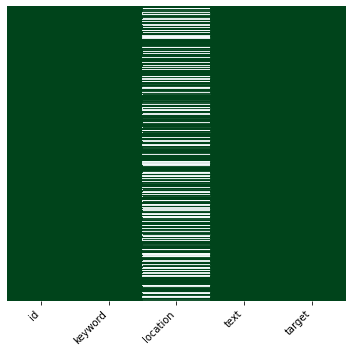

In [138]:
#Memvisualisasikan nilai-nilai yang hilang pada dataset
#Terlihat feature location banyak yang kosong.

ax, fig = plt.subplots(figsize=(5,5))
ax = sns.heatmap(dataset.isna(),yticklabels=False,cbar=False,cmap='BuGn_r', alpha = 0.9)
plt.xticks(rotation = 45, ha="right")
plt.tight_layout()

# Menganalisis Feature Dataset Tweet

**Feature ID**

In [139]:
#ID tidak memiliki relasi dengan feature Target, feature ini akan dihapus.
dataset["id"]

0            0
1            1
2            2
3            3
4            4
         ...  
11365    11365
11366    11366
11367    11367
11368    11368
11369    11369
Name: id, Length: 11370, dtype: int64

In [140]:
dataset = dataset.drop("id", axis='columns')

**Feature KEYWORD**

In [141]:
#Keyword terbanyak adalah thunderstorm, dan disini terlihat ada 219 nilai keyword
dataset["keyword"].describe()

count            11370
unique             219
top       thunderstorm
freq                93
Name: keyword, dtype: object

In [142]:
#Melihat beberapa kelompok nilai yang ada pada feature keyword.
dataset[~dataset["keyword"].isna()]["keyword"].unique().tolist()[:30]

['ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags']

**Feature LOCATION**

In [143]:
#Location terbanyak adalah United States, dan disini terlihat ada 4504 nilai Location
dataset["location"].describe()

count              7952
unique             4504
top       United States
freq                 96
Name: location, dtype: object

In [144]:
#Melihat julah nilai yang hilang, dan terlihat 30% kosong
dataset["location"].isna().value_counts(normalize=True)*100

False    69.938434
True     30.061566
Name: location, dtype: float64

In [145]:
#Melihat beberapa kelompok nilai yang ada pada feature location.
#Feature ini terdapat symbol, char yang tidak konsisten menunjukan tempat (location)
dataset[~dataset["location"].isna()]["location"].values.tolist()[:30]

['New York City',
 'Morgantown, WV',
 'OC',
 'London, England',
 'Bharat',
 'Accra, Ghana',
 'Searching',
 'HYDERABAD',
 'Reno, NV',
 'Worldwide',
 'Italy',
 "` ˗ˏˋ i'm⠀waiting⠀for⠀you⠀to⠀pour⠀my⠀𝘀𝗶𝗻𝘀⠀onto⠀me⠀;⠀call⠀me⠀your⠀𝘭𝘰𝘷𝘦𝘳⠀whispering⠀hymns⠀to⠀my⠀ear⠀,⠀crucify⠀me⠀in⠀claims⠀of⠀praising⠀me .",
 'Okielahoma',
 'Havana 3am',
 'Washington, DC',
 'India',
 'Salta, Argentina',
 'Wherever socks go in the dryer',
 'Kuala Lumpur',
 'Sydney, New South Wales',
 'Nigeria',
 'Davanagere, India ',
 'Lyndhurst, OH',
 'Covina, Ca',
 'Colorado, Brighton',
 'North Carolina, USA',
 'kurger bing',
 'Faridabad, India',
 '60',
 'ngovhela Mahunguni']

**Feature TEXT**

In [146]:
#Melihat nilai feature text.
#Terlihat nilai test berisi link url, emoji, symbol, escape char, tab, dll yang perlu dihilangkan.
dataset["text"].values.tolist()[:30]

['Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims\' houses and some houses and vehicles were set ablaze…',
 'Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. Po…',
 'Arsonist sets cars ablaze at dealership https://t.co/gOQvyJbpVI',
 'Arsonist sets cars ablaze at dealership https://t.co/0gL7NUCPlb https://t.co/u1CcBhOWh9',
 '"Lord Jesus, your love brings freedom and pardon. Fill me with your Holy Spirit and set my heart ablaze with your l… https://t.co/VlTznnPNi8',
 'If this child was Chinese, this tweet would have gone viral. Social media would be ablaze. SNL would have made a racist j…',
 'Several houses have been set ablaze in Ngemsibaa village, Oku sub division in the North West Region of Cameroon by… https://t.co/99uHGAzxy2',
 'Asansol: A BJP office in Salanpur village was set ablaze last night. BJP has alleged that TMC is behind the incident. Police has b…',
 "National Security M

**Feature TARGET**

In [147]:
#Melihat jumlah dan perbandingan feature target
dataset["target"].value_counts()

0    9256
1    2114
Name: target, dtype: int64

In [148]:
#Terlihat 18,59% tweet merupakan Disaster (Bencana)
dataset["target"].value_counts(normalize=True)*100

0    81.407212
1    18.592788
Name: target, dtype: float64

# Preprocessing Dataset

In [149]:
#Membuat Fungsi untuk menghapus URL, emoji, html dan tanda baca.

#Refensi: https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet
def hapus_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

#Referensi: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def hapus_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # Kode Emoticon
        u'\U0001F300-\U0001F5FF'  # Kode symbols & pictograph
        u'\U0001F680-\U0001F6FF'  # Kode transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # Kode flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Referensi: https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
def hapus_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

#Referensi: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
def hapus_tandaBaca(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [150]:
# Menerapkan Fungsi untuk menghapus URL, emoji, html dan tanda baca
# Output berupa field baru bernama clean_text
dataset['clean_text'] = dataset['text'].apply(lambda x: hapus_URL(x))
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: hapus_emoji(x))
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: hapus_html(x))
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: hapus_tandaBaca(x))

dataset.head()

,keyword,location,text,target,clean_text
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,Communal violence in Bhainsa Telangana Stones ...
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,Telangana Section 144 has been imposed in Bhai...
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,Lord Jesus your love brings freedom and pardon...


In [151]:
#Tokenized, Mengecilkan huruf dan menghilangkan stop_word pada field clean_text
nltk.download('punkt')
nltk.download('stopwords')

#Referensi: https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/
dataset['tokenized'] = dataset['clean_text'].apply(word_tokenize)

#Referensi: https://www.geeksforgeeks.org/isupper-islower-lower-upper-python-applications/
dataset['lower'] = dataset['tokenized'].apply(
    lambda x: [word.lower() for word in x])

#Referensi: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
dataset['no_stopwords'] = dataset['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])
dataset['no_stopwords'] = [' '.join(map(str, l)) for l in dataset['no_stopwords']]


dataset.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,Communal violence in Bhainsa Telangana Stones ...,"[Communal, violence, in, Bhainsa, Telangana, S...","[communal, violence, in, bhainsa, telangana, s...",communal violence bhainsa telangana stones pel...
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,Telangana Section 144 has been imposed in Bhai...,"[Telangana, Section, 144, has, been, imposed, ...","[telangana, section, 144, has, been, imposed, ...",telangana section 144 imposed bhainsa january ...
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]",arsonist sets cars ablaze dealership
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]",arsonist sets cars ablaze dealership
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,Lord Jesus your love brings freedom and pardon...,"[Lord, Jesus, your, love, brings, freedom, and...","[lord, jesus, your, love, brings, freedom, and...",lord jesus love brings freedom pardon fill hol...


In [152]:
#Lemmatization adalah pengubahan kata dengan makna yang sama menjadi satu bentuk karena 
#komputer akan membacanya sebagai data yang berbeda sehingga proses analisis akan menjadi 
#lebih sulit. Contohnya, “eat”,  “ate”, “eaten”, “eating” merupakan bentuk dari “eat”, sehingga akan diubah menjadi “eat”.

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemma = WordNetLemmatizer()

#Referensi: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
#nltk.pos_tag() mengembalikan tupel dengan tag POS. Kuncinya di sini adalah memetakan tag 
#POS NLTK ke format yang akan diterima lemmatizer wordnet. Fungsi yang didefinisikan di 
#bawah ini melakukan pekerjaan pemetaan ini. get_wordnet_pos()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

#Lemmatize field "no_stopwords" dengan POS tag yang sesuai.
dataset['lemmatized'] =  dataset['no_stopwords'].apply(
    lambda x: [lemma.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])

dataset.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords,lemmatized
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,Communal violence in Bhainsa Telangana Stones ...,"[Communal, violence, in, Bhainsa, Telangana, S...","[communal, violence, in, bhainsa, telangana, s...",communal violence bhainsa telangana stones pel...,"[communal, violence, bhainsa, telangana, stone..."
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,Telangana Section 144 has been imposed in Bhai...,"[Telangana, Section, 144, has, been, imposed, ...","[telangana, section, 144, has, been, imposed, ...",telangana section 144 imposed bhainsa january ...,"[telangana, section, 144, impose, bhainsa, jan..."
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]",arsonist sets cars ablaze dealership,"[arsonist, set, car, ablaze, dealership]"
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]",arsonist sets cars ablaze dealership,"[arsonist, set, car, ablaze, dealership]"
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,Lord Jesus your love brings freedom and pardon...,"[Lord, Jesus, your, love, brings, freedom, and...","[lord, jesus, your, love, brings, freedom, and...",lord jesus love brings freedom pardon fill hol...,"[lord, jesus, love, brings, freedom, pardon, f..."


In [153]:
#Menghapus data duplikat
print("Shape awal:", dataset.shape)

#Referensi: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
dataset.drop_duplicates(subset ="clean_text",inplace = True)

print("Shape akhir:", dataset.shape)

Shape awal: (11370, 9)
Shape akhir: (10999, 9)


# Split Dataset

In [154]:
#Dataset akan dibagi menjadi 3, yaitu dataset train, test dan validation.
#dataset diambil dari field lemmatized.
X = dataset['lemmatized']
y = dataset['target']

#Awalnya dataset "lemmatized" akan dibagi menjadi 80% untuk dataset train dan 20% untuk dataset Test.
X_train, X_rem, y_train, y_rem  = train_test_split(
    X, 
    y, 
    stratify = y, 
    test_size = 0.2, 
    random_state = 321
)

#Kemudian 20% dataset dibagi sama rata kembali untuk dataset Test dan Validation.
X_test, X_val, y_test, y_val = train_test_split(
     X_rem, 
     y_rem, 
     stratify = y_rem, 
     test_size = 0.5, 
     random_state = 321)


print('Train Set: ', X_train.shape, y_train.shape)
print('Test Set: ', X_test.shape, y_test.shape)
print('Validation Set: ', X_val.shape, y_val.shape)

Train Set:  (8799,) (8799,)
Test Set:  (1100,) (1100,)
Validation Set:  (1100,) (1100,)


# Word Embedding

In [155]:
# Tokenize words
# Referensi: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = Tokenizer()

#Data validasi (x_val) tidak di tekenize untuk dapat mensimulasikan real world. Sehingga data x_val tidak masuk ke dalam kamus.
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

#mengubah token korpus teks menjadi urutan bilangan integer
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

#digunakan untuk memastikan bahwa semua urutan dalam daftar memiliki panjang yang sama
X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

#Menghitung Ukuran kosakata
vocabSize = len(tokenizer.index_word) + 1

print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 19749


In [156]:
#Menyiapkan pre-trained word vectors GLove
#Referensi: https://nlp.stanford.edu/projects/glove/
embeddings_index = {}
embedding_dim = 300
hits = 0
misses = 0
num_tokens = vocabSize

# Read word vectors
with open('/content/drive/MyDrive/SOSMED_4/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

        
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
Converted 13010 words (6738 misses)


# Modeling

In [157]:
#Membuat callbback untuk menghinadari overfitting
#Referensi: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#Memonitor nilai  "val_loss" dan epochs  yang tidak ada peningkatan sebanyak 2 kali. Dan menggunakan nilai epch dengan hasil terbaik.
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

#Merekam waktu yang dibutuhkan oleh setiap epoch untuk membandingkan model nantinya.
#Referensi: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


## Training & Evaluation (SGD, LSTM) ModelA




In [158]:
modelA = Sequential([
  Embedding(
      vocabSize, 
      embedding_dim, 
      input_length=256, 
      embeddings_initializer=Constant(embedding_matrix), 
      trainable=False
      ),
  SpatialDropout1D(0.2),
  LSTM(128, dropout=0.3, recurrent_dropout=0.2),
  BatchNormalization(),
  Dense(64, activation='relu'),
  Dropout(0.3),
  Dense(1, activation='sigmoid')                
])
optimizerA = SGD(learning_rate=0.0001, momentum=0.9)
modelA.compile(loss='binary_crossentropy', 
              optimizer=optimizerA, 
              metrics=['accuracy'])
modelA.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 256, 300)          5924700   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_12 (LSTM)              (None, 128)               219648    
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)              

In [159]:
#Merekam Waktu yang dibutuhkan dan Melakukan Fit Model dengan dataset train dan validasi
time_callbackA = TimeHistory()
historyA = modelA.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_val, y_val),verbose=2,callbacks=[early_stopping, time_callbackA])

Epoch 1/20
35/35 - 37s - loss: 0.7178 - accuracy: 0.5765 - val_loss: 0.6775 - val_accuracy: 0.6264 - 37s/epoch - 1s/step
Epoch 2/20
35/35 - 34s - loss: 0.6785 - accuracy: 0.6192 - val_loss: 0.6614 - val_accuracy: 0.7082 - 34s/epoch - 971ms/step
Epoch 3/20
35/35 - 34s - loss: 0.6518 - accuracy: 0.6425 - val_loss: 0.6462 - val_accuracy: 0.7518 - 34s/epoch - 982ms/step
Epoch 4/20
35/35 - 36s - loss: 0.6201 - accuracy: 0.6738 - val_loss: 0.6310 - val_accuracy: 0.7745 - 36s/epoch - 1s/step
Epoch 5/20
35/35 - 34s - loss: 0.6016 - accuracy: 0.6941 - val_loss: 0.6147 - val_accuracy: 0.7827 - 34s/epoch - 968ms/step
Epoch 6/20
35/35 - 34s - loss: 0.5840 - accuracy: 0.7180 - val_loss: 0.5986 - val_accuracy: 0.7882 - 34s/epoch - 964ms/step
Epoch 7/20
35/35 - 34s - loss: 0.5710 - accuracy: 0.7228 - val_loss: 0.5811 - val_accuracy: 0.8000 - 34s/epoch - 982ms/step
Epoch 8/20
35/35 - 35s - loss: 0.5532 - accuracy: 0.7408 - val_loss: 0.5628 - val_accuracy: 0.8055 - 35s/epoch - 1s/step
Epoch 9/20
35/35 

In [160]:
#Menghitung total dan rerata waktu yang dibutuhkan proses fit.
rerataWaktuA = mean(time_callbackA.times)
totalWaktuA = sum(time_callbackA.times)

print("Rerata Waktu =", round(rerataWaktuA, 2), 'detik')
print("Total Waktu =", round(totalWaktuA, 2), 'detik')

Rerata Waktu = 34.61 detik
Total Waktu = 692.17 detik


In [161]:
#Menguji Model dengan dataset test.
AccModelA = modelA.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 2s 68ms/step - loss: 0.4528 - accuracy: 0.8245


## Training & Evaluation (LSTM, Bidirectional, ADAM) ModelB

In [162]:
modelB = Sequential([
    Embedding(
        num_tokens, 
        embedding_dim,
        input_length=256,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False 
        ),
    Conv1D(filters=1024, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    Dropout(0.3),
    Bidirectional(LSTM(1024, return_sequences = True)),
    Dropout(0.3),
    Bidirectional(LSTM(512)),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizerADAM = Adam(learning_rate=1e-4)

modelB.compile(loss='binary_crossentropy', 
              optimizer=optimizerADAM, 
              metrics=['accuracy'])
modelB.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 256, 300)          5924700   
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 1024)         922624    
                                                                 
 dropout_25 (Dropout)        (None, 256, 1024)         0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 256, 2048)        16785408  
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 256, 2048)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 1024)             10489856  
 nal)                                                

In [163]:
#Merekam Waktu yang dibutuhkan dan Melakukan Fit Model dengan dataset train dan validasi
time_callbackB = TimeHistory()
historyB = modelB.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping, time_callbackB])

Epoch 1/20
35/35 - 114s - loss: 0.4599 - accuracy: 0.8082 - val_loss: 0.3470 - val_accuracy: 0.8445 - 114s/epoch - 3s/step
Epoch 2/20
35/35 - 107s - loss: 0.3325 - accuracy: 0.8673 - val_loss: 0.3185 - val_accuracy: 0.8700 - 107s/epoch - 3s/step
Epoch 3/20
35/35 - 107s - loss: 0.2962 - accuracy: 0.8784 - val_loss: 0.3121 - val_accuracy: 0.8755 - 107s/epoch - 3s/step
Epoch 4/20
35/35 - 106s - loss: 0.2756 - accuracy: 0.8877 - val_loss: 0.3079 - val_accuracy: 0.8755 - 106s/epoch - 3s/step
Epoch 5/20
35/35 - 106s - loss: 0.2573 - accuracy: 0.8961 - val_loss: 0.3066 - val_accuracy: 0.8709 - 106s/epoch - 3s/step
Epoch 6/20
35/35 - 106s - loss: 0.2262 - accuracy: 0.9115 - val_loss: 0.3131 - val_accuracy: 0.8909 - 106s/epoch - 3s/step
Epoch 7/20
35/35 - 107s - loss: 0.1884 - accuracy: 0.9287 - val_loss: 0.3001 - val_accuracy: 0.8800 - 107s/epoch - 3s/step
Epoch 8/20
35/35 - 107s - loss: 0.1485 - accuracy: 0.9485 - val_loss: 0.3190 - val_accuracy: 0.8809 - 107s/epoch - 3s/step
Epoch 9/20
35/35

In [164]:
#Menghitung total dan rerata waktu yang dibutuhkan proses fit.
rerataWaktuB = mean(time_callbackB.times)
totalWaktuB = sum(time_callbackB.times)

print("Rerata Waktu =", round(rerataWaktuB, 2), 'detik')
print("Total Waktu =", round(totalWaktuB, 2), 'detik')

Rerata Waktu = 107.08 detik
Total Waktu = 1284.95 detik


In [165]:
#Menguji Model dengan dataset test.
AccModelB = modelB.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 6s 156ms/step - loss: 0.2920 - accuracy: 0.8891


##Training & Evaluation (LSTM, ADAM) ModelC

In [166]:
modelC = Sequential([
  Embedding(
        num_tokens, 
        embedding_dim,
        input_length=256,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False 
        ),
  LSTM(embedding_dim, return_sequences=True),
  Dropout(0.25),
  LSTM(embedding_dim),
  Dropout(0.25),
  Dense(embedding_dim, activation="relu"),
  Dropout(0.5),
  Dense(1, activation='sigmoid')
])

modelC.compile(loss='binary_crossentropy', 
              optimizer= Adam(learning_rate=0.001), 
              metrics=['accuracy'])
modelC.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 256, 300)          5924700   
                                                                 
 lstm_15 (LSTM)              (None, 256, 300)          721200    
                                                                 
 dropout_29 (Dropout)        (None, 256, 300)          0         
                                                                 
 lstm_16 (LSTM)              (None, 300)               721200    
                                                                 
 dropout_30 (Dropout)        (None, 300)               0         
                                                                 
 dense_24 (Dense)            (None, 300)               90300     
                                                                 
 dropout_31 (Dropout)        (None, 300)             

In [167]:
#Merekam Waktu yang dibutuhkan dan Melakukan Fit Model dengan dataset train dan validasi
time_callbackC = TimeHistory()
historyC = modelC.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping, time_callbackC])

Epoch 1/20
35/35 - 11s - loss: 0.3736 - accuracy: 0.8460 - val_loss: 0.3413 - val_accuracy: 0.8573 - 11s/epoch - 307ms/step
Epoch 2/20
35/35 - 7s - loss: 0.2947 - accuracy: 0.8799 - val_loss: 0.2994 - val_accuracy: 0.8782 - 7s/epoch - 207ms/step
Epoch 3/20
35/35 - 7s - loss: 0.2664 - accuracy: 0.8917 - val_loss: 0.3062 - val_accuracy: 0.8836 - 7s/epoch - 209ms/step
Epoch 4/20
35/35 - 7s - loss: 0.2420 - accuracy: 0.9020 - val_loss: 0.3119 - val_accuracy: 0.8718 - 7s/epoch - 210ms/step
Epoch 5/20
35/35 - 7s - loss: 0.2148 - accuracy: 0.9110 - val_loss: 0.3213 - val_accuracy: 0.8764 - 7s/epoch - 209ms/step
Epoch 6/20
35/35 - 7s - loss: 0.1862 - accuracy: 0.9242 - val_loss: 0.3260 - val_accuracy: 0.8845 - 7s/epoch - 209ms/step
Epoch 7/20
35/35 - 7s - loss: 0.1422 - accuracy: 0.9434 - val_loss: 0.3332 - val_accuracy: 0.8727 - 7s/epoch - 209ms/step


In [168]:
#Menghitung total dan rerata waktu yang dibutuhkan proses fit.
rerataWaktuC = mean(time_callbackC.times)
totalWaktuC = sum(time_callbackC.times)

print("Rerata Waktu =", round(rerataWaktuC, 2), 'detik')
print("Total Waktu =", round(totalWaktuC, 2), 'detik')

Rerata Waktu = 7.81 detik
Total Waktu = 54.65 detik


In [169]:
#Menguji Model dengan dataset test.
AccModelC = modelC.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 1s 20ms/step - loss: 0.3059 - accuracy: 0.8809


In [170]:
X_test

array([[   0,    0,    0, ...,  996,   58,    8],
       [   0,    0,    0, ...,   90,  129,  965],
       [   0,    0,    0, ...,  153, 8026, 7824],
       ...,
       [   0,    0,    0, ...,   10,  165, 7667],
       [   0,    0,    0, ...,  120, 1333,   85],
       [   0,    0,    0, ...,   79,  101, 3004]], dtype=int32)

## Training & Evaluation (GRU, Bidirectional, ADAM) ModelD



In [171]:
modelD = Sequential([
  Embedding(
        num_tokens, 
        embedding_dim,
        input_length=256,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False 
        ),
  GRU(embedding_dim, return_sequences=True),
  Dropout(0.25),
  Bidirectional(GRU(embedding_dim)),
  Dropout(0.25),
  Dense(150, activation="relu"),
  Dropout(0.25),
  Dense(1, activation='sigmoid')
])

modelD.compile(loss='binary_crossentropy', 
              optimizer= Adam(learning_rate=0.001), 
              metrics=['accuracy'])
modelD.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 256, 300)          5924700   
                                                                 
 gru_4 (GRU)                 (None, 256, 300)          541800    
                                                                 
 dropout_32 (Dropout)        (None, 256, 300)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 600)              1083600   
 nal)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 600)               0         
                                                                 
 dense_26 (Dense)            (None, 150)               90150     
                                                     

In [172]:
#Merekam Waktu yang dibutuhkan dan Melakukan Fit Model dengan dataset train dan validasi
time_callbackD = TimeHistory()
historyD = modelD.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping, time_callbackD])

Epoch 1/20
35/35 - 16s - loss: 0.3770 - accuracy: 0.8448 - val_loss: 0.3191 - val_accuracy: 0.8664 - 16s/epoch - 443ms/step
Epoch 2/20
35/35 - 9s - loss: 0.2927 - accuracy: 0.8770 - val_loss: 0.3166 - val_accuracy: 0.8736 - 9s/epoch - 271ms/step
Epoch 3/20
35/35 - 10s - loss: 0.2737 - accuracy: 0.8865 - val_loss: 0.3399 - val_accuracy: 0.8755 - 10s/epoch - 272ms/step
Epoch 4/20
35/35 - 10s - loss: 0.2466 - accuracy: 0.8945 - val_loss: 0.3235 - val_accuracy: 0.8745 - 10s/epoch - 274ms/step
Epoch 5/20
35/35 - 10s - loss: 0.2255 - accuracy: 0.9062 - val_loss: 0.3420 - val_accuracy: 0.8845 - 10s/epoch - 272ms/step
Epoch 6/20
35/35 - 9s - loss: 0.1953 - accuracy: 0.9191 - val_loss: 0.3501 - val_accuracy: 0.8636 - 9s/epoch - 271ms/step
Epoch 7/20
35/35 - 9s - loss: 0.1663 - accuracy: 0.9295 - val_loss: 0.4064 - val_accuracy: 0.8845 - 9s/epoch - 269ms/step


In [173]:
#Menghitung total dan rerata waktu yang dibutuhkan proses fit.
rerataWaktuD = mean(time_callbackD.times)
totalWaktuD = sum(time_callbackD.times)

print("Rerata Waktu =", round(rerataWaktuD, 2), 'detik')
print("Total Waktu =", round(totalWaktuD, 2), 'detik')

Rerata Waktu = 10.36 detik
Total Waktu = 72.53 detik


In [174]:
#Menguji Model dengan dataset test.
AccModelD = modelD.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 1s 24ms/step - loss: 0.3161 - accuracy: 0.8818


# Perbandingan Setiap Model

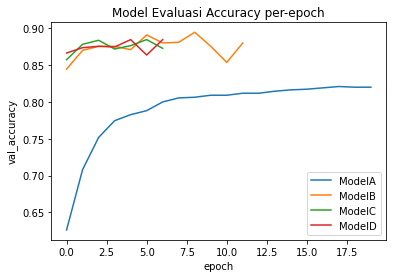

In [175]:
# Rangkuman history dari proses fit accuracy setiap Model dengan dataset val per-epoch
plt.plot(historyA.history['val_accuracy'])
plt.plot(historyB.history['val_accuracy'])
plt.plot(historyC.history['val_accuracy'])
plt.plot(historyD.history['val_accuracy'])
plt.title('Model Evaluasi Accuracy per-epoch')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['ModelA', 'ModelB', 'ModelC', 'ModelD'], loc='lower right')
plt.show()

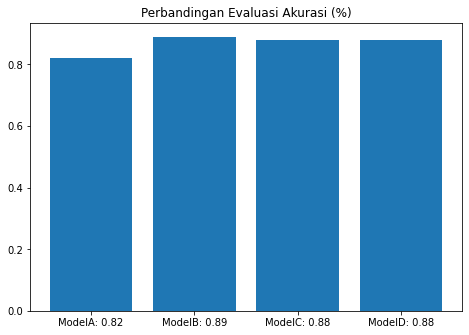

In [176]:
#Menampilkan Perbandingan Evaluasi Akurasi dari dataset test di setiap model.
a = round(AccModelA[1], 2)
b = round(AccModelB[1], 2)
c = round(AccModelC[1], 2)
d = round(AccModelD[1], 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['ModelA: '+str(a), 'ModelB: '+str(b), 'ModelC: '+str(c), 'ModelD: '+str(d)]
akurasi = [a,b,c,d]
ax.bar(models,akurasi)
plt.title('Perbandingan Evaluasi Akurasi (%)')
plt.show()

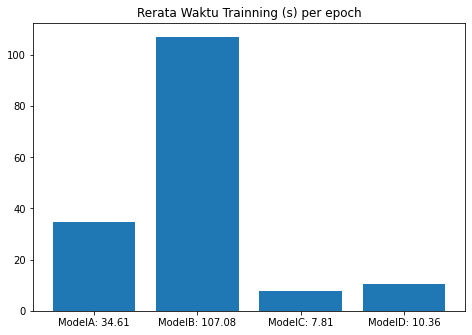

In [177]:
#Menampilkan Perbandingan Rerata Waktu Trainning di setiap model.
RWa = round(rerataWaktuA, 2)
RWb = round(rerataWaktuB, 2)
RWc = round(rerataWaktuC, 2)
RWd = round(rerataWaktuD, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['ModelA: '+str(RWa), 'ModelB: '+str(RWb), 'ModelC: '+str(RWc), 'ModelD: '+str(RWd)]
rerata = [RWa,RWb,RWc,RWd]
ax.bar(models,rerata)
plt.title('Rerata Waktu Trainning (s) per epoch')
plt.show()

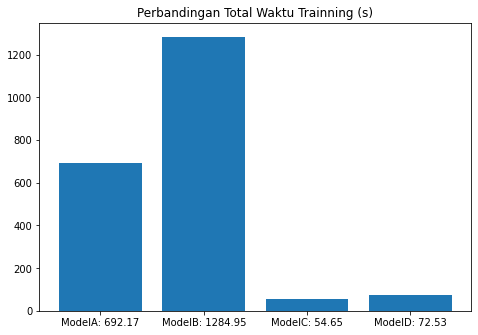

In [178]:
#Menampilkan Perbandingan Total Waktu Trainning di setiap model.
TWa = round(totalWaktuA, 2)
TWb = round(totalWaktuB, 2)
TWc = round(totalWaktuC, 2)
TWd = round(totalWaktuD, 2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['ModelA: '+str(TWa), 'ModelB: '+str(TWb), 'ModelC: '+str(TWc), 'ModelD: '+str(TWd)]
rerata = [TWa,TWb,TWc,TWd]
ax.bar(models,rerata)
plt.title('Perbandingan Total Waktu Trainning (s)')
plt.show()

#Custom Sample Dataset Test
Sumber dataset: https://www.kaggle.com/c/nlp-getting-started dan mengambil dataset train.csv (File sudah di tambahkan ke GDrive pada link sebelumnya)

In [179]:
# Classify custom sample

df_test = pd.read_csv ('/content/drive/MyDrive/SOSMED_4/train.csv')

#Cleanning
df_test['clean_text'] = df_test['text'].apply(lambda x: hapus_URL(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: hapus_emoji(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: hapus_html(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: hapus_tandaBaca(x))

#Referensi: https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/
df_test['tokenized'] = df_test['clean_text'].apply(word_tokenize)

#Referensi: https://www.geeksforgeeks.org/isupper-islower-lower-upper-python-applications/
df_test['lower'] = df_test['tokenized'].apply(
    lambda x: [word.lower() for word in x])

#Referensi: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
df_test['no_stopwords'] = df_test['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])
df_test['no_stopwords'] = [' '.join(map(str, l)) for l in df_test['no_stopwords']]

#Lemmatize field "no_stopwords" dengan POS tag yang sesuai.
df_test['lemmatized'] =  df_test['no_stopwords'].apply(
    lambda x: [lemma.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])

df_test.head()

,id,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords,lemmatized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...",deeds reason earthquake may allah forgive us,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...",residents asked shelter place notified officer...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...",got sent photo ruby alaska smoke wildfires pou...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [180]:
#mengubah token korpus teks menjadi urutan bilangan integer
sequences_test2 = tokenizer.texts_to_sequences(df_test['lemmatized'])

#digunakan untuk memastikan bahwa semua urutan dalam daftar memiliki panjang yang sama
X_test2 = pad_sequences(sequences_test2, maxlen=256, truncating='pre')

In [181]:
modelA.evaluate(X_test2, df_test['target'], verbose = 1)
modelB.evaluate(X_test2, df_test['target'], verbose = 1)
modelC.evaluate(X_test2, df_test['target'], verbose = 1)
modelD.evaluate(X_test2, df_test['target'], verbose = 1)

238/238 [==============================] - 5s 21ms/step - loss: 0.6552 - accuracy: 0.6767


[0.6551997661590576, 0.6767371892929077]